In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Import DESlib components
from deslib.des.knora_e import KNORAE

# Import imbalanced-learn for more advanced resampling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
def load_and_preprocess_data():
    # Load the datasets (same as before)
    df_net = pd.read_csv('data/linux_driver_net.csv')
    df_scsi = pd.read_csv('data/linux_driver_scsi.csv')
    df_ext3 = pd.read_csv('data/linux_ext3.csv')
    df_ipv4 = pd.read_csv('data/linux_ipv4.csv')
    
    # Combine datasets
    combined_df = pd.concat([df_net, df_scsi, df_ext3, df_ipv4], ignore_index=True)
    
    # Fill missing values
    numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
    combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].mean())
    combined_df = combined_df.dropna()
    
    # Print dataset info
    print("Class distribution:")
    print(combined_df['AgingRelatedBugs'].value_counts())
    print(f"Imbalance ratio: {combined_df['AgingRelatedBugs'].value_counts()[0] / combined_df['AgingRelatedBugs'].value_counts()[1]}")
    
    # Prepare features and target
    X = combined_df.drop(['Filename', 'AgingRelatedBugs'], axis=1)
    y = combined_df['AgingRelatedBugs']
    
    # Feature scaling 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, X.columns

In [3]:
def create_data_splits(X, y):
    # Split into 50% train, 25% DSEL, 25% test to give more training data
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train_temp, y_train_temp, test_size=0.33, random_state=42, stratify=y_train_temp)
    
    print("Training set class distribution:", Counter(y_train))
    print("DSEL set class distribution:", Counter(y_dsel))
    print("Test set class distribution:", Counter(y_test))
    
    return X_train, y_train, X_dsel, y_dsel, X_test, y_test

In [4]:
def apply_advanced_resampling(X_train, y_train, method='smote_tomek', ratio=0.5):
    """
    Apply more advanced resampling techniques to address class imbalance
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    method : str
        Resampling method to use ('smote_tomek', 'smote_enn', 'borderline_smote', 'adasyn')
    ratio : float
        Desired ratio of minority to majority class (0.5 means minority will be half the size of majority)
    """
    # Count minority samples
    minority_count = Counter(y_train)[1]
    
    # Choose appropriate k for methods based on minority class size
    k_neighbors = min(5, minority_count - 1)  # Must be less than minority count
    
    if k_neighbors <= 1:
        print("Too few minority samples for advanced resampling. Using simple SMOTE.")
        method = 'smote'
    
    print(f"Applying {method} resampling...")
    
    # Different resampling techniques
    if method == 'smote_tomek':
        # Combined over and undersampling
        resampler = SMOTETomek(sampling_strategy=ratio, random_state=42, smote=SMOTE(k_neighbors=k_neighbors))
    elif method == 'smote_enn':
        # Another combined approach
        resampler = SMOTEENN(sampling_strategy=ratio, random_state=42, smote=SMOTE(k_neighbors=k_neighbors))
    elif method == 'borderline_smote':
        # Focus on borderline cases
        resampler = BorderlineSMOTE(sampling_strategy=ratio, random_state=42, k_neighbors=k_neighbors)
    elif method == 'adasyn':
        # Adaptive Synthetic Sampling
        resampler = ADASYN(sampling_strategy=ratio, random_state=42, n_neighbors=k_neighbors)
    else:
        # Regular SMOTE
        resampler = SMOTE(sampling_strategy=ratio, random_state=42, k_neighbors=k_neighbors)
    
    # Apply resampling
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    
    print("Original class distribution:", Counter(y_train))
    print("Resampled class distribution:", Counter(y_resampled))
    
    return X_resampled, y_resampled

In [5]:
def create_classifier_pool(X_train, y_train, n_classifiers=50, max_features=0.7):
    """
    Creates a pool of diverse Random Forest classifiers with feature bagging
    """
    pool = []
    n_features = X_train.shape[1]
    
    for i in range(n_classifiers):
        # Randomly select a subset of features for this classifier (feature bagging)
        n_features_to_use = int(max(3, n_features * max_features * np.random.uniform(0.5, 1.0)))
        
        # Create classifier with different parameters
        clf = RandomForestClassifier(
            n_estimators=50,
            max_features=n_features_to_use,
            max_depth=None,
            min_samples_split=2,
            bootstrap=True,
            random_state=i
        )
        
        # Train the classifier
        clf.fit(X_train, y_train)
        pool.append(clf)
    
    return pool

In [6]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate all relevant metrics including PD, PF, and Balance
    """
    # Get confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate AUC if probabilities are available
    # auc = roc_auc_score(y_true, y_prob)
    
    # Calculate Error rates
    error_I = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
    error_II = fn / (tp + fn) * 100 if (tp + fn) > 0 else 0
    
    # Calculate PD (Probability of Detection)
    pd_metric = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    # Calculate PF (Probability of False Alarms)
    pf_metric = (fp / (tn + fp)) * 100 if (tn + fp) > 0 else 0
    
    # Calculate Balance
    bal_metric = 100 - (math.sqrt((0 - pf_metric)**2 + (100 - pd_metric)**2) / math.sqrt(2))
    
    return {
        'error_I': error_I,
        'error_II': error_II,
        'pd': pd_metric,
        'pf': pf_metric,
        'balance': bal_metric,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

In [7]:
def run_knora_e(X_train, y_train, X_dsel, y_dsel, X_test, y_test, 
                resampling_method='smote_tomek', resampling_ratio=0.5, 
                k_neighbors=5, pool_size=50):
    """
    Run KNORA-E algorithm with optimizations for imbalanced data
    """
    # Step 1: Apply advanced resampling to training data
    X_train_resampled, y_train_resampled = apply_advanced_resampling(
        X_train, y_train, method=resampling_method, ratio=resampling_ratio
    )
    
    # Step 2: Create a pool of diverse classifiers
    print(f"Creating a pool of {pool_size} classifiers...")
    classifier_pool = create_classifier_pool(X_train_resampled, y_train_resampled, n_classifiers=pool_size)
    
    # Step 3: Configure and run KNORA-E
    print("Configuring KNORA-E...")
    knora_e = KNORAE(
        pool_classifiers=classifier_pool,
        k=k_neighbors,
        DFP=True,  # Use Dynamic Frienemy Pruning to improve performance
        with_IH=True,  # Use Instance Hardness to distinguish easy and hard samples
        IH_rate=0.3,  # Default threshold for instance hardness
        random_state=42
    )
    
    # Fit KNORA-E to the DSEL data
    print("Fitting KNORA-E...")
    knora_e.fit(X_dsel, y_dsel)
    
    # Make predictions
    print("Making predictions...")
    y_pred = knora_e.predict(X_test)
    y_prob = knora_e.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_prob)
    metrics = calculate_metrics(y_test, y_pred)
    
    # Print results
    print("\nKNORA-E Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Error I (%): {metrics['error_I']:.2f}")
    print(f"Error II (%): {metrics['error_II']:.2f}")
    print(f"PD (%): {metrics['pd']:.2f}")
    print(f"PF (%): {metrics['pf']:.2f}")
    print(f"Balance (%): {metrics['balance']:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('KNORA-E Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return y_pred, y_prob, auc, metrics


Class distribution:
AgingRelatedBugs
0    3380
1      20
Name: count, dtype: int64
Imbalance ratio: 169.0
Training set class distribution: Counter({0: 1698, 1: 10})
DSEL set class distribution: Counter({0: 837, 1: 5})
Test set class distribution: Counter({0: 845, 1: 5})
Applying smote_tomek resampling...
Original class distribution: Counter({0: 1698, 1: 10})
Resampled class distribution: Counter({0: 1698, 1: 1698})
Creating a pool of 50 classifiers...
Configuring KNORA-E...
Fitting KNORA-E...


/home/futabandit/repos/HiveBugExtractionARBs/linux_bug_classifier/venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Making predictions...

KNORA-E Results:
AUC: 0.9475
Error I (%): 0.59
Error II (%): 100.00
PD (%): 0.00
PF (%): 0.59
Balance (%): 29.29

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       845
           1       0.00      0.00      0.00         5

    accuracy                           0.99       850
   macro avg       0.50      0.50      0.50       850
weighted avg       0.99      0.99      0.99       850


Confusion Matrix:
[[840   5]
 [  5   0]]


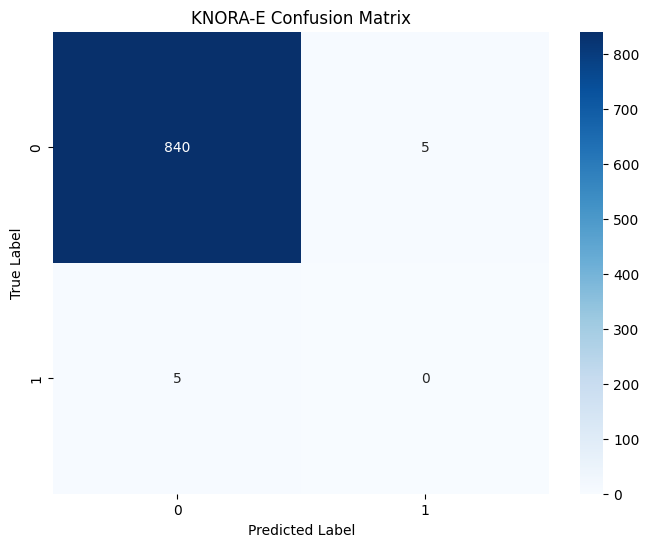

In [8]:
def run_optimized_des():
    # Load and preprocess data
    X, y, feature_names = load_and_preprocess_data()
    
    # Create data splits with modified proportions
    X_train, y_train, X_dsel, y_dsel, X_test, y_test = create_data_splits(X, y)
    
    # Run KNORA-E with optimized parameters
    y_pred, y_prob, auc, metrics = run_knora_e(
        X_train, y_train, X_dsel, y_dsel, X_test, y_test,
        resampling_method='smote_tomek',  # SMOTETomek often works well
        resampling_ratio=1.0,  # Create equal class distribution
        k_neighbors=7,  # Standard value
        pool_size=50  # Reasonable balance between diversity and speed
    )
    
    return y_pred, y_prob, auc, metrics

# Run the optimized DES approach
y_pred, y_prob, auc, metrics = run_optimized_des()